In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.noise import *

In [2]:
# AtLAST
zmin = 1
zmax = 5

Omega_field = 7500 #deg^2

chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

Pei = 5.6e4 #Jy / sr
Lambda = 0.01 # 1 / Mpc, usual cut for HI

In [3]:
dchi = np.mean(np.diff(chibs))

In [4]:
IHi_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/zmin_%.5f_zmax_%.5f_Lambda_%.5f.npy'%(zmin, zmax, Lambda)
print(IHi_kappa_fname)
IHi_kappa = np.load(IHi_kappa_fname)

/scratch/users/delon/LIMxCMBL/IHiKappa/zmin_1.00000_zmax_5.00000_Lambda_0.01000.npy


In [5]:
(chimax - chimin)//dchi

105.0

In [6]:
eIeI, eLOeLO, eIeLO, eLOeI = get_eHIeHI(Pei, chimin, chimax, dchi, Lambda, elems = True)
eHIeHI = eIeI + eLOeLO - eIeLO - eLOeI

computing eIeI
computing eIeLO
computing eLOeI
computing eLOeLO


100%|██████████| 256/256 [00:07<00:00, 34.37it/s]


[]

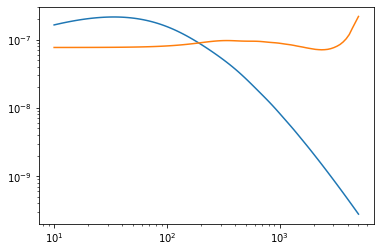

In [7]:
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD)


# beam=1.4, noise=7
from scipy.interpolate import interp1d
N0_ells = np.logspace(1, np.log10(5000), 500)
with open('LIMxCMBL/N0.npy', 'rb') as f:
    N0 = np.load(f)
    
f_N0 = interp1d(x = N0_ells, y = N0)

    
plt.plot(ells, ClKK)
plt.plot(ells, f_N0(ells))
plt.loglog()

Text(0.5, 1.0, "$\\langle \\epsilon^{I,{\\sf HI}}_\\ell(\\chi) \\epsilon^{I, {\\sf Hi}}_{-\\ell}(\\chi')\\rangle'$")

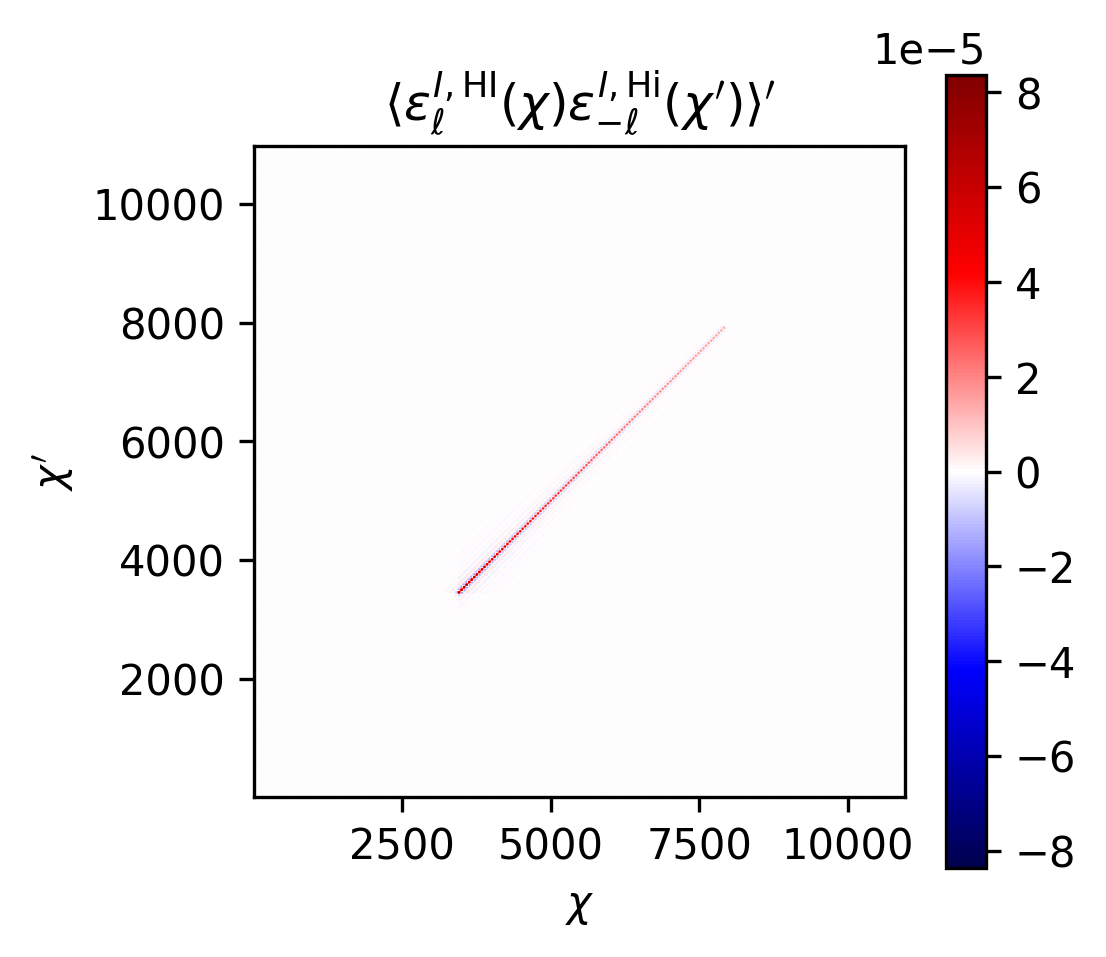

In [8]:
vminmax = np.max(np.abs(eHIeHI))
plt.figure(figsize=(3.5,3.5), dpi=300, facecolor='w',)
 
# plot data
plt.imshow(eHIeHI, 
           origin='lower',
          cmap = 'seismic',
          vmin = -vminmax,
          vmax =  vminmax,
          extent=[chibs[0], chibs[-1], chibs[0], chibs[-1]])

plt.colorbar()
plt.xlabel(r'$\chi$')
plt.ylabel(r"$\chi'$")
plt.title(r"$\langle \epsilon^{I,{\sf HI}}_\ell(\chi) \epsilon^{I, {\sf Hi}}_{-\ell}(\chi')\rangle'$")

# Naive Noise Dominated

Text(0.5, 1.0, "inverted $\\langle \\epsilon^{I,{\\sf HI}}_\\ell(\\chi) \\epsilon^{I, {\\sf Hi}}_{-\\ell}(\\chi')\\rangle'$")

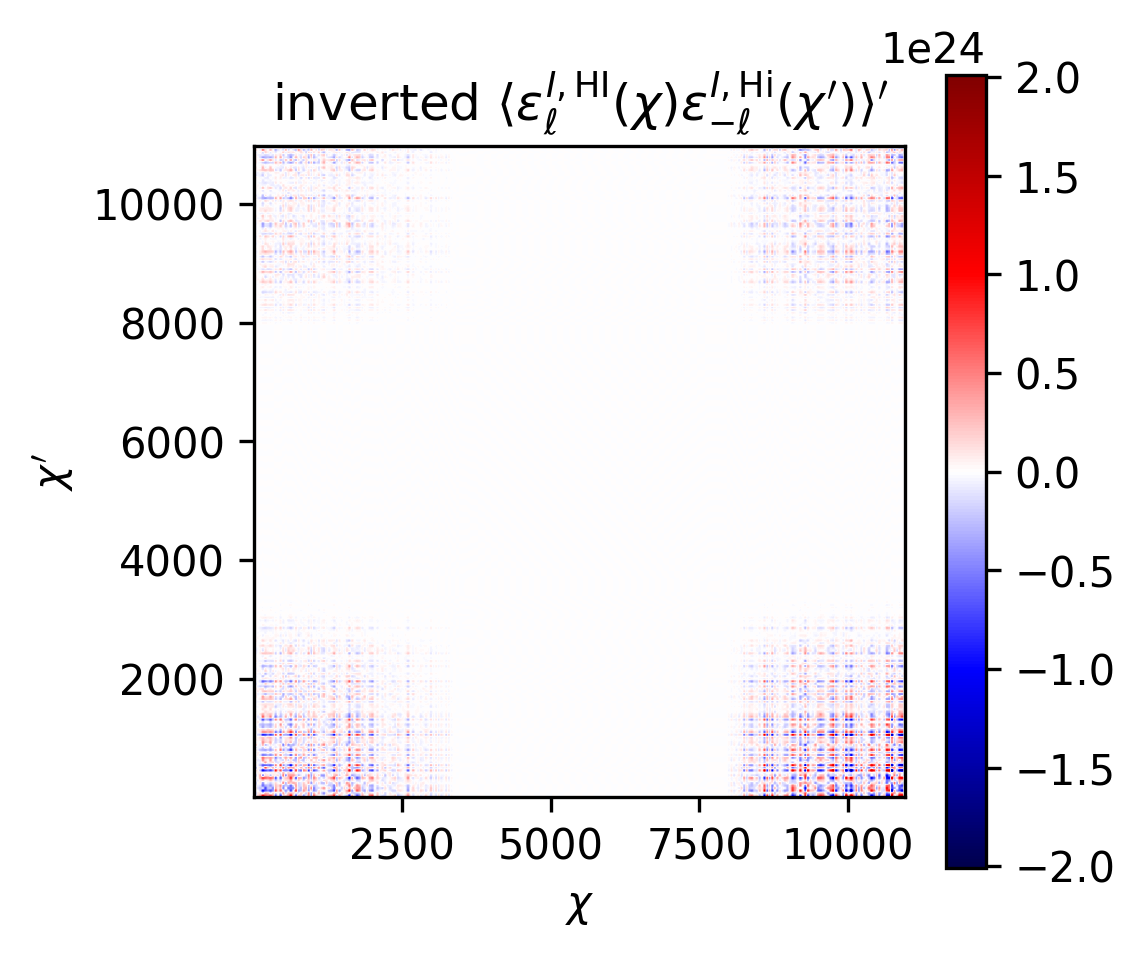

In [9]:
inv_eHIeHI = np.linalg.inv(eHIeHI)
vminmax = np.max(np.abs(inv_eHIeHI))
plt.figure(figsize=(3.5,3.5), dpi=300, facecolor='w',)

# figure out bounds
 
# plot data
plt.imshow(inv_eHIeHI, 
           origin='lower',
          cmap = 'seismic',
          vmin = -vminmax,
          vmax =  vminmax,
          extent=[chibs[0], chibs[-1], chibs[0], chibs[-1]])

plt.colorbar()
plt.xlabel(r'$\chi$')
plt.ylabel(r"$\chi'$")
plt.title(r"inverted $\langle \epsilon^{I,{\sf HI}}_\ell(\chi) \epsilon^{I, {\sf Hi}}_{-\ell}(\chi')\rangle'$")

In [10]:
eHIeHI.shape

(256, 256)

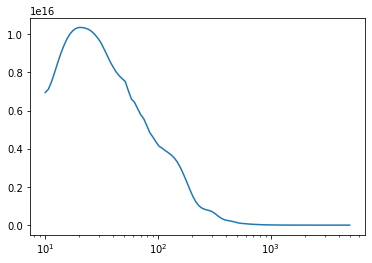

In [11]:
inv_eHIeHI = np.linalg.inv(eHIeHI)
unstable_SNR2_per_mode = np.einsum('ij, jk, ki-> i', IHi_kappa, inv_eHIeHI, IHi_kappa.T)
unstable_SNR2_per_mode *= 1/(ClKK + f_N0(ells)) * dchi**2
plt.plot(ells, unstable_SNR2_per_mode)
plt.xscale('log')

In [12]:
eHIeHI_64 = eHIeHI.astype(np.float64)
IHi_kappa_64 = IHi_kappa.astype(np.float64)

intermediate = np.linalg.solve(eHIeHI_64, IHi_kappa_64.T)
SNR2_per_mode = np.sum(IHi_kappa_64 * intermediate.T, axis=1)
SNR2_per_mode *= 1/(ClKK + f_N0(ells)) * dchi**2

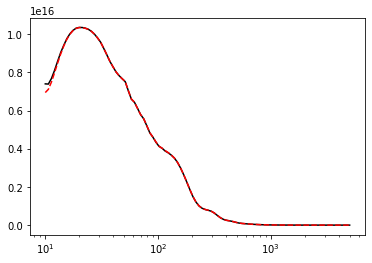

In [13]:
plt.plot(ells, SNR2_per_mode, 'k')
plt.plot(ells, unstable_SNR2_per_mode, 'r--')

plt.xscale('log')

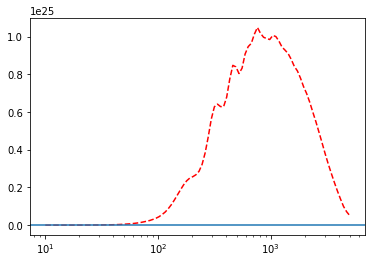

In [14]:
plt.plot(ells, ells**4 * SNR2_per_mode, 'r--')
plt.axhline(0)
plt.xscale('log')

# no filtering snr per mode

In [15]:
from  LIMxCMBL.kernels import *
f_KLIM   = get_f_KI()
f_Kkappa = get_f_Kkappa()

f_KLIM_windowed = apply_window(f_K = f_KLIM,
                               chimin = chimin,
                               chimax = chimax)
I_kappa = d_delta_integral(f_KLIM_windowed, f_Kkappa)

/share/software/user/open/py-jupyter/1.0.0_py39/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Casting input data from float128 to float64 for imshow.
  func(*args, **kwargs)
/share/software/user/open/py-jupyter/1.0.0_py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Casting input data from float128 to float64 for imshow.
  fig.canvas.print_figure(bytes_io, **kw)


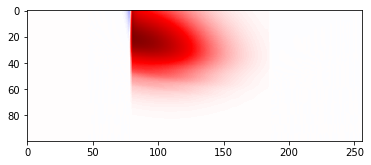

In [16]:
_vv = np.max(np.abs(I_kappa))
plt.imshow(I_kappa, vmin = -_vv, vmax = _vv, cmap='seismic')

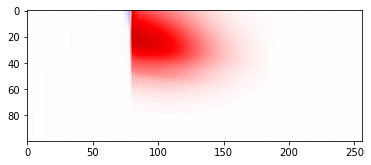

In [17]:
plt.imshow(IHi_kappa, vmin = -_vv, vmax = _vv, cmap='seismic')

In [18]:
np.allclose(np.diag(np.diag(eIeI)), eIeI, atol = 0.0, rtol = 1e-8)

True

In [19]:
SNR2_per_mode_no_cut = np.zeros_like(ells)
#becuase no cut makes everything diagonal we can do a direct sum

for chib_idx in range(len(chibs)):
    chi = chibs[chib_idx]
    if(chi < chimin or chi > chimax):
        continue
    SNR2_per_mode_no_cut += I_kappa.T[chib_idx]**2 / (Pei/chi**2) * dchi
SNR2_per_mode_no_cut *= 1/(ClKK + f_N0(ells)) 

In [20]:
SNR2_per_mode_no_cut_but_Hi_data = np.zeros_like(ells)
#becuase no cut makes everything diagonal we can do a direct sum

for chib_idx in range(len(chibs)):
    chi = chibs[chib_idx]
    if(chi < chimin or chi > chimax):
        continue
    SNR2_per_mode_no_cut_but_Hi_data += IHi_kappa.T[chib_idx]**2  / (Pei/chi**2) * dchi
SNR2_per_mode_no_cut_but_Hi_data *= 1/(ClKK + f_N0(ells)) 

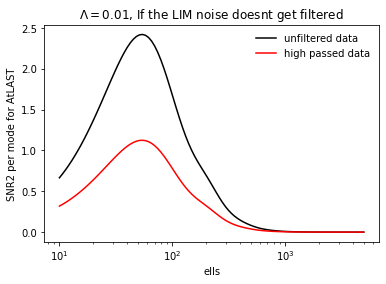

In [21]:
plt.figure(facecolor = 'w')
plt.plot(ells, SNR2_per_mode_no_cut, 'k', label='unfiltered data')
plt.plot(ells, SNR2_per_mode_no_cut_but_Hi_data, 'r', label='high passed data')

plt.xscale('log')
plt.xlabel('ells')
plt.ylabel('SNR2 per mode for AtLAST')
plt.title('$\Lambda=%.2f$, If the LIM noise doesnt get filtered'%(Lambda))
plt.legend(frameon=False)